In [1]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap
import sys
sys.path.append('../definitions')
import def_model as mod_def
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

In [2]:
start_date = pd.Timestamp('2024-03-20')
end_date = pd.Timestamp('2024-07-10')

df = mod_def.combine_resampled_data(start_date, end_date)
# df = df.iloc[:,1:7]
print(f"This is the head of the df: \n", df.head())
print(f"This is the info:\n" ,df.info())
flag_counts = df['flag'].value_counts()
proportion_flag_1_to_0 = (flag_counts[1.0] / flag_counts[0.0])*100
print(f"Flag = 1 counts: {flag_counts[1.0]}")
print(f"Proportion of flag = 1 to flag = 0: {proportion_flag_1_to_0} %")

This is the head of the df: 
     NS_SQUID   Z_SQUID   NS_Fluxgate  EW_Fluxgate    Z_Fluxgate   H Component  \
0 -17.218172  0.263233  10934.303393   -42.359410 -22656.440907  10934.385443   
1 -17.199095  0.317575  10934.335773   -42.639808 -22656.444363  10934.418915   
2 -17.069690  0.255518  10934.388935   -42.276737 -22656.497270  10934.470664   
3 -17.053298  0.289818  10934.401460   -42.308557 -22656.484653  10934.483313   
4 -17.142593  0.255207  10934.392687   -42.265653 -22656.573902  10934.474373   

   flag  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  
<class 'pandas.core.frame.DataFrame'>
Index: 817968 entries, 0 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   NS_SQUID     817968 non-null  float64
 1   Z_SQUID      817968 non-null  float64
 2   NS_Fluxgate  817968 non-null  float64
 3   EW_Fluxgate  817968 non-null  float64
 4   Z_Fluxgate   817968 non-null  float64
 5   H Component  8179

In [3]:
# # Plot the time series
# plt.style.use('fivethirtyeight')
# df.plot(subplots=True,
#         layout=(6, 3),
#         figsize=(22,22),
#         fontsize=10, 
#         linewidth=2,
#         sharex=False,
#         title='Visualization of the original Time Series')
# plt.show()

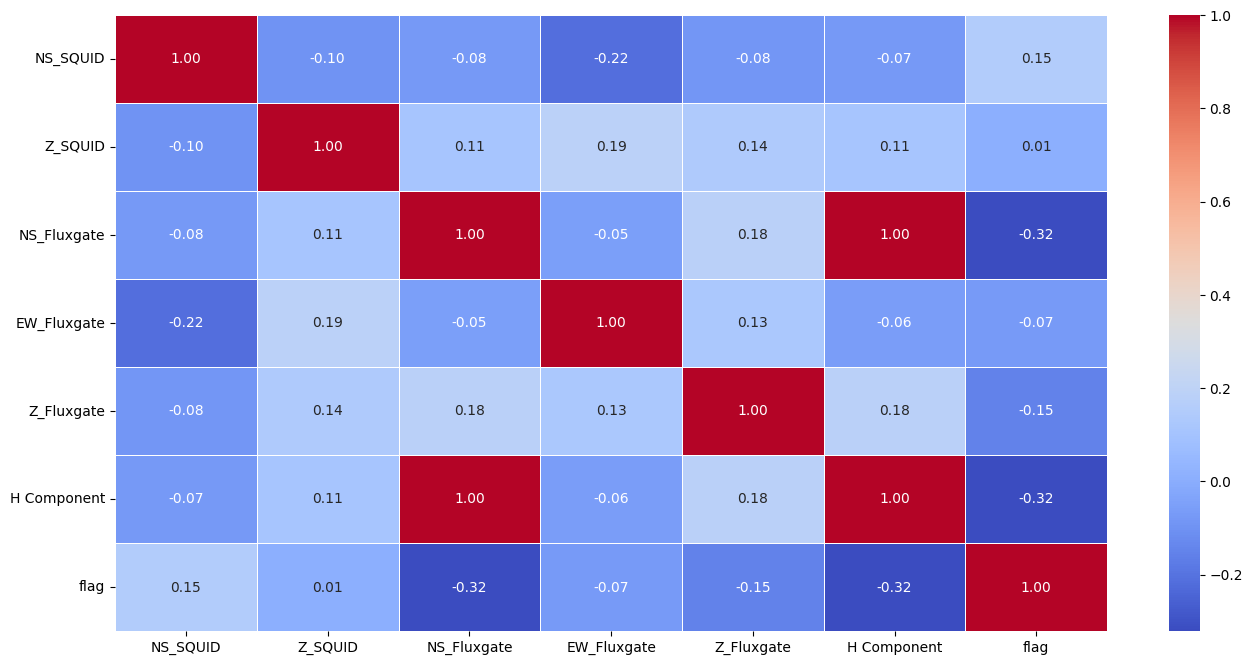

In [4]:
# Let's also draw a heatmap visualization of the correlation matrix
corr_matrix = df.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [5]:
df_transform = df.loc[:,:'H Component'].copy().pct_change(1)
df_transform['flag'] = df['flag']
df_transform.head()

,NS_SQUID,Z_SQUID,NS_Fluxgate,EW_Fluxgate,Z_Fluxgate,H Component,flag
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,-0.001108,0.206439,2.961323e-06,0.006620,1.525688e-07,3.061090e-06,0.0
2,-0.007524,-0.195408,4.861902e-06,-0.008515,2.335171e-06,4.732729e-06,0.0
3,-0.000960,0.134237,1.145469e-06,0.000753,-5.568675e-07,1.156791e-06,0.0
4,0.005236,-0.119425,-8.023606e-07,-0.001014,3.939196e-06,-8.175818e-07,0.0


In [6]:
df_transform.fillna(method='bfill', inplace=True)
df_transform.head()

/var/folders/xc/v6tb2xnd0r17mbd2bzzfq3_00000gn/T/ipykernel_1137/969860104.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_transform.fillna(method='bfill', inplace=True)


,NS_SQUID,Z_SQUID,NS_Fluxgate,EW_Fluxgate,Z_Fluxgate,H Component,flag
0,-0.001108,0.206439,2.961323e-06,0.006620,1.525688e-07,3.061090e-06,0.0
1,-0.001108,0.206439,2.961323e-06,0.006620,1.525688e-07,3.061090e-06,0.0
2,-0.007524,-0.195408,4.861902e-06,-0.008515,2.335171e-06,4.732729e-06,0.0
3,-0.000960,0.134237,1.145469e-06,0.000753,-5.568675e-07,1.156791e-06,0.0
4,0.005236,-0.119425,-8.023606e-07,-0.001014,3.939196e-06,-8.175818e-07,0.0


In [7]:
# Split train and test data
test_size = 0.3
split_idx = int((1 - test_size) * len(df))
train_features, test_features = df_transform.iloc[0:split_idx, 0:6], df_transform.iloc[split_idx:len(df_transform), 0:6]
train_labels, test_labels = df_transform.iloc[0:split_idx, 6:7], df_transform.iloc[split_idx:len(df_transform), 6:7]


# I want to use a T-days window of input data for predicting target_class
# It means I need to prepend (T-1) last train records to the 1st test window
T = 45  # my choice of the timesteps window

prepend_features = train_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features, test_features], axis=0)

train_features.shape, train_labels.shape, test_features.shape, test_labels.shape


((572577, 6), (572577, 1), (245435, 6), (245391, 1))

In [8]:
# Rescale the features
from sklearn.preprocessing import StandardScaler  # MinMaxScaler

scaler = StandardScaler()  # MinMaxScaler(feature_range=(-1,1))
scaled_train_features = pd.DataFrame(scaler.fit_transform(train_features.values),
                                     index=train_features.index,
                                     columns=train_features.columns)
# The Scaler is fit on the training set and then applied to the test set
scaled_test_features = pd.DataFrame(scaler.transform(test_features.values),
                                    index=test_features.index,
                                    columns=test_features.columns)

scaled_train_features.shape, scaled_test_features.shape

((572577, 6), (245435, 6))

In [9]:
# Create sequences of T timesteps
X_train, y_train = [], []
for i in range(train_labels.shape[0] - (T-1)):
    X_train.append(scaled_train_features.iloc[i:i+T].values)
    y_train.append(train_labels.iloc[i + (T-1)])
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_test, y_test = [], []
for i in range(test_labels.shape[0]):
    X_test.append(scaled_test_features.iloc[i:i+T].values)
    y_test.append(test_labels.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)  

print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (572533, 45, 6), (572533, 1)
Test data dimensions: (245391, 45, 6), (245391, 1)


LSTM Model

In [ ]:
# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 50                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='max',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_test[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,verbose=0,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['acc'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_acc'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

layers=[8, 8, 8, 1], train_examples=572533, test_examples=245391
batch = 572533, timesteps = 45, features = 6, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0


/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester_2/Skripsie/Code/Bigdata_Event_Detection/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 45, 8)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 45, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 45, 8)          │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,673 (6.54 KB)

 Trainable params: 1,625 (6.35 KB)

 Non-trainable params: 48 (192.00 B)

None


/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester_2/Skripsie/Code/Bigdata_Event_Detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate
  current = self.get_monitor_value(logs)
